## Second principles: Fitting a mixture model to inferred 'true' values which is related to an observable with an uncertainty

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set_palette('colorblind',20)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('axes',labelsize=15) 

import pandas as pd
import pystan

npts = 2000

def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

Lets pull a sample of fractional uncertainties from the true data

In [2]:
sfile = '../data/KepxDR2/rcxyu18.csv'
df = pd.read_csv(sfile,index_col=0)
M = df.ast_MKs
tau = df.ast_M_err
f = np.abs(tau/M)

Lets build our synthetic population no. 1

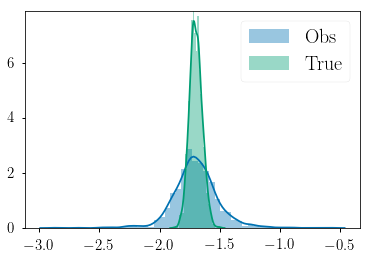

In [3]:
rQ = .60
rmu = -1.7
rsigma = .05
runc = 0.1
fi = f[:int(npts*rQ)]
fo = f[int(npts*rQ):int(npts*rQ) + int((1-rQ)*npts)]

iM_true = np.random.randn(int(npts*rQ)) * rsigma + rmu
iunc = np.abs(fi * iM_true)
# iunc = np.abs(runc * iM_true)
# iunc = runc*np.ones(len(iM_true))
iM_obs = iM_true + np.random.randn(int(npts*rQ))*iunc

sns.distplot(iM_obs, label='Obs')
sns.distplot(iM_true, label='True')
plt.legend(fontsize=20)
plt.show()

Now synthetic population no. 2

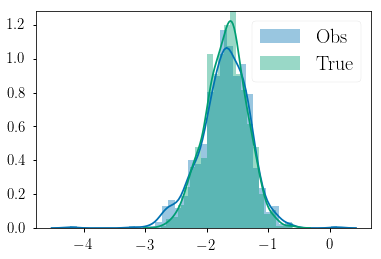

In [4]:
rmuo = rmu
rsigo = .35

oM_true = np.random.randn(int((1-rQ)*npts)) * rsigo + rmuo
ounc = np.abs(fo * oM_true)
# ounc = np.abs(runc * oM_true) #uncertainties
# ounc = runc*np.ones(len(oM_true))
oM_obs = oM_true + np.random.randn(int((1-rQ)*npts))*ounc

sns.distplot(oM_obs, label='Obs')
sns.distplot(oM_true, label='True')
plt.legend(fontsize=20)
plt.show()

Now lets combine them!

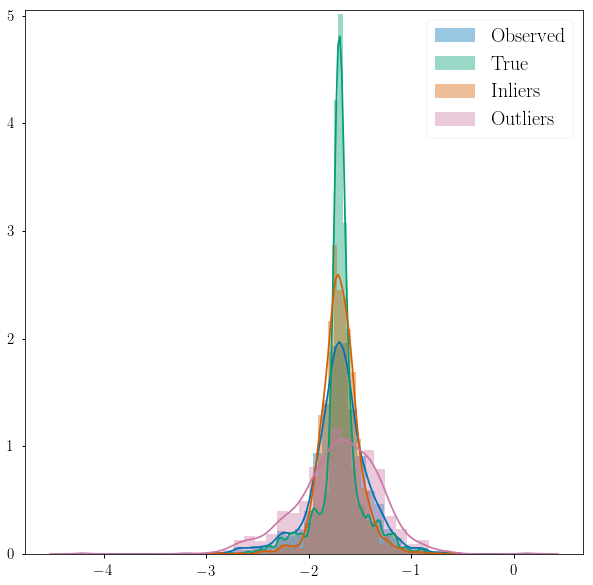

In [5]:
M_obs = np.append(oM_obs, iM_obs)
M_unc = np.append(ounc, iunc)
M_true = np.append(oM_true, iM_true)
fsyn = M_unc/M_obs
fig = plt.figure(figsize=(10,10))
sns.distplot(M_obs, label='Observed')
sns.distplot(M_true, label='True')
sns.distplot(iM_obs, label='Inliers')
sns.distplot(oM_obs, label='Outliers')
plt.legend(fontsize=20)
plt.show()

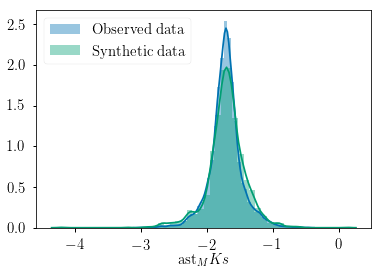

In [6]:
sns.distplot(M, label='Observed data')
sns.distplot(M_obs, label='Synthetic data')
plt.legend(fontsize=15)
plt.show()

#### They look similar! There is a slight skew to the right in the synthetic data that we need to fix

$p(\theta_{RC}, \{\alpha_i\} | \{\mathcal{D}_i\}) \propto p(\theta_{RC})\prod p(\mathcal{D}_i | \theta_{RC}, \alpha_i)p(\alpha_i | \theta_{RC})$

In [37]:
second = '''
data{
    int<lower=0> N;
    real Mobs[N];
    real Munc[N];
}
parameters {
    real mu;
    real<lower=0.> sigma;
    real<lower = 0., upper=1.> Q;
    real<lower=.3> sigo;
    
    real Mtrue_std[N];
}
transformed parameters {
    real Mtrue[N];
    real tsigo;
    
    for (n in 1:N){
        Mtrue[n] = mu + sigma*Mtrue_std[n];
    }
    tsigo = sigo/sigma;
}
model {
    mu ~ uniform(-1.9, -1.5); //p(theta)
    sigma ~ normal(.05, 0.02);//''
    sigo ~ uniform (.3, 3.);  //''
    Q ~ uniform(0., 1.);      //''

    Mobs ~ normal(Mtrue, Munc);  //p(D | theta, alpha)
    
    //p(alpha | theta)
    for (n in 1:N)
        target += log_mix(Q,
                    normal_lpdf(Mtrue_std[n] | 0, 1),
                    normal_lpdf(Mtrue_std[n] | 0, tsigo));
}
'''
sm = pystan.StanModel(model_code=second)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_80db577b67c13253d59e695c4ef69180 NOW.


In [38]:
data = {'N': npts,
       'Mobs': M_obs,
       'Munc' : M_unc}
init = {'mu' : rmu,
       'sigma': rsigma,
       'sigo': rsigo,
       'Q' : rQ}
fit = sm.sampling(data=data, iter=2000, chains=2, init = [init, init])

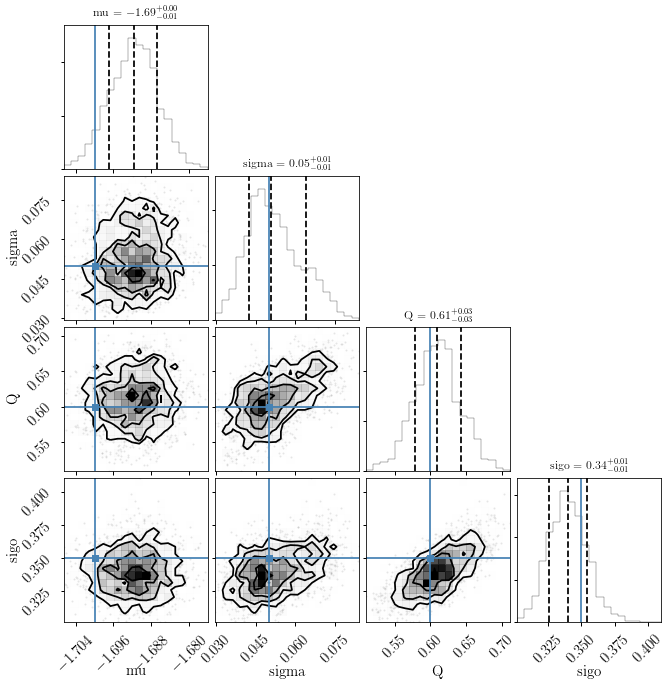

In [39]:
import corner
chain = np.array([fit['mu'],fit['sigma'],fit['Q'],fit['sigo']]).T
truths=[rmu, rsigma, rQ, rsigo]
corner.corner(chain,labels=['mu','sigma','Q','sigo'],\
                  truths=truths,\
                  quantiles=[0.16, 0.5, 0.84],\
                  show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

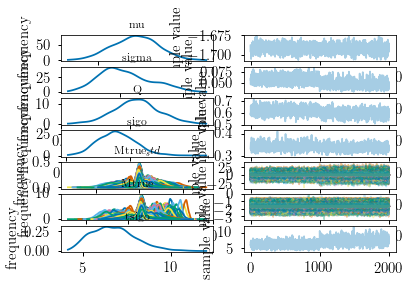

In [40]:
fit.plot()
plt.show()

In [41]:
mu = np.median(fit['mu'])
sigma = np.median(fit['sigma'])
sigo = (np.median(fit['sigo']))
Q = np.median(fit['Q'])

x = np.linspace(M_obs.min(), M_obs.max(), 1000)
fg = normal(x, mu, sigma)
bg = normal(x, mu, sigo)
L = Q*fg + (1-Q)*bg
rL = rQ * normal(x, rmu, rsigma) + (1-Q)*normal(x, rmu, rsigo)

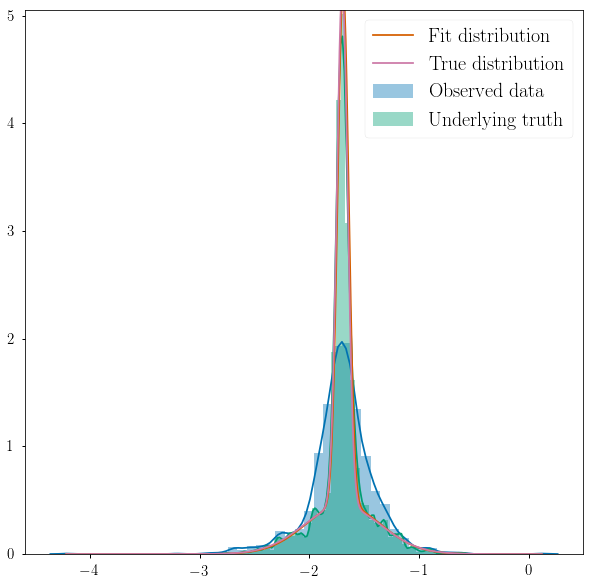

In [42]:
fig = plt.figure(figsize=(10,10))
sns.distplot(M_obs, label='Observed data')
sns.distplot(M_true, label='Underlying truth')
plt.plot(x, L, label='Fit distribution')
plt.plot(x, rL, label='True distribution')
plt.legend(fontsize=20)
plt.show()

In [ ]:
print(fit)

In [ ]:
s = fit.summary()
print(s['summary'][:,-1])
rhat = s['summary'][:,-1]
rhatfin = rhat[np.isfinite(rhat)]
print('Total number of Rhats: '+str(len(rhat)))
print('Total number of Rhats with the NaN values removed: '+str(len(rhatfin)))
sns.distplot(rhatfin)
plt.show()